# Purpose:  
How representations of data influence structures found by kmeans clustering?  
## SOP  
> Raw → PCA → K-means → Evaluate → Compare with SVM → Interpret clusters  
> Maybe also compare with neural networks?
## MNIST(high dimension, 784)  
- Raw -> could cluster discover different structure?
- PCA to different dims -> do the structure become more evident? 
- What info could dif PCA dim contain?
- Evaluation: SVM(ideal upper boundary) vs. Kmeans Clustering quality  
## Covid(low dimension, ~10)  
- Is PCA still useful?  
- Could we discover the mode of survival/death through clustering?

# 0. Headfiles

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from myutils import finddim
from myutils import evaluate_kmeans
SEED = 42
seed = np.random.seed(SEED)

# 1. Step 1: Prepare datasets  
- MNIST 
- Covid

## 1.1 load dataset

In [2]:
# 1. MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# TODO 
# 2. Covid dataset

/opt/miniconda3/envs/ubc_ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## 1.2 check dataset info

### MNIST

In [3]:
print(f"MNIST feature shape:{mnist.data.shape}")
print(f"MNIST labels: {np.unique(mnist.target)}")

MNIST feature shape:(70000, 784)
MNIST labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


### TODO: Covid Data

# 2. Step 2: PCA Dimensionality Reduction  
Transform raw data into multiple PCA representations to investigate how different feature spaces affect clustering behavior.
## SOP
- Normalize data
- Compute full PCA
- Plot explained variance
- Choose PCA dimensions
- Transform dataset into selected PCA spaces
- Visualize low-dimensional PCA


## 2.1 PCA for MNIST

### Normalize Data  
- What?  
    - scale and normalize data
- Why?
    - avoid huge value and huge variance influencing top principle components  
- How?  
    - For MNIST, scale pixel values to [0,1], then standard normalization  
    - TODO: For Covid dataset  

In [4]:
# load data
x_mnist = mnist.data 
y_mnist = mnist.target.astype(int).reshape(-1,1)
# print(f'input shape: {x_mnist.shape}')
# print(f'label shape: {y_mnist.shape}') 

# scale PCA to [0,1]
print(f"pixel value scope: {[np.min(x_mnist), np.max(x_mnist)]}") # check maximum value
# print(f"unique pixel values: {np.unique(x_mnist)}") # check if inormal value
x_mnist = x_mnist.astype(float) / np.max(x_mnist)
print(f'pixel value scope after scaling: {[np.min(x_mnist), np.max(x_mnist)]}')

# ideally standardize to mean=0, standard variance=1 for every feature
print(f"mean and std: {np.mean(x_mnist):.4f}, {np.std(x_mnist):.4f}")
scaler = StandardScaler()
x_mnist = scaler.fit_transform(x_mnist)
print(f"mean and std after standardization: {np.mean(x_mnist):.4f}, {np.unique(np.std(x_mnist, axis=0)[:])}")

pixel value scope: [0.0, 255.0]
pixel value scope after scaling: [0.0, 1.0]
mean and std: 0.1309, 0.3084
mean and std after standardization: 0.0000, [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Compute Full PCA

In [5]:
pca_full = PCA(n_components=x_mnist.shape[1])
x_mnist_pca_full = pca_full.fit_transform(x_mnist)
D = pca_full.explained_variance_
V = pca_full.components_.T

In [6]:
print(f'Principle components: {D[:5]} ...')

Principle components: [40.57172851 29.05682915 26.87856923 20.80096479 18.12446406] ...


### Plot Explained Variance  
$$
\begin{aligned}
& cumulative(k) = \frac{\Sigma_{i=1}^{k}\lambda_i}{\Sigma_{i=1}^{784}\lambda_i}
\end{aligned}
$$

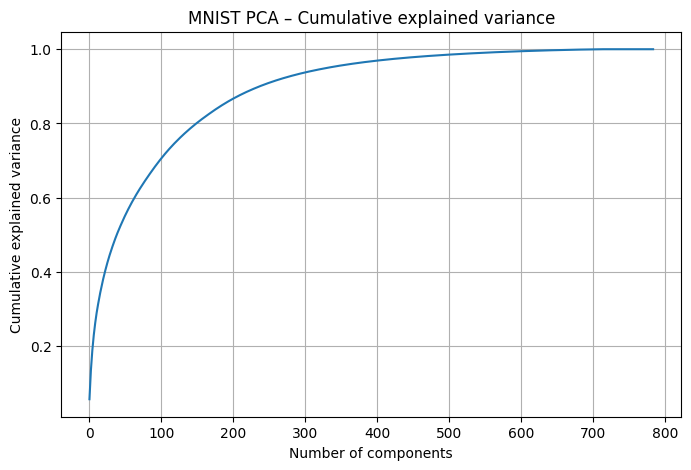

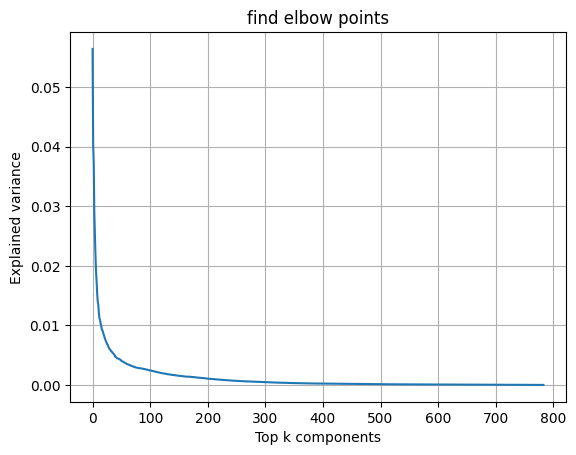

In [7]:
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("MNIST PCA – Cumulative explained variance")
plt.grid(True)
plt.show()

plt.figure() 
plt.title('find elbow points')
plt.xlabel("Top k components")
plt.ylabel("Explained variance")
plt.plot(pca_full.explained_variance_ratio_)
plt.grid(True)
plt.show()

### Choose PCA dimensions

In [8]:
threshold = [0.8,0.9,0.95,0.99] # edit this
pca_dims = [2,3,20,50]
for thres in threshold:
    k = finddim(cum_var,thres)
    pca_dims.append(k)
    print(f"dims for {thres*100}%:", k)
pca_dims.append(784)
print(f'chosen dimensions: {pca_dims}')

dims for 80.0%: 150
dims for 90.0%: 238
dims for 95.0%: 332
dims for 99.0%: 544
chosen dimensions: [2, 3, 20, 50, 150, 238, 332, 544, 784]


### Transform dataset into selected PCA spaces

In [9]:
x_mnist_pca = {}   
pca_models = {}    

for d in pca_dims:
    pca = PCA(n_components=d)
    x_mnist_pca[d] = pca.fit_transform(x_mnist)
    pca_models[d] = pca
    print(f"PCA dim={d}: shape={x_mnist_pca[d].shape}")

PCA dim=2: shape=(70000, 2)
PCA dim=3: shape=(70000, 3)
PCA dim=20: shape=(70000, 20)
PCA dim=50: shape=(70000, 50)
PCA dim=150: shape=(70000, 150)
PCA dim=238: shape=(70000, 238)
PCA dim=332: shape=(70000, 332)
PCA dim=544: shape=(70000, 544)
PCA dim=784: shape=(70000, 784)


### Visualize Low Dimensional PCA

#### 2d

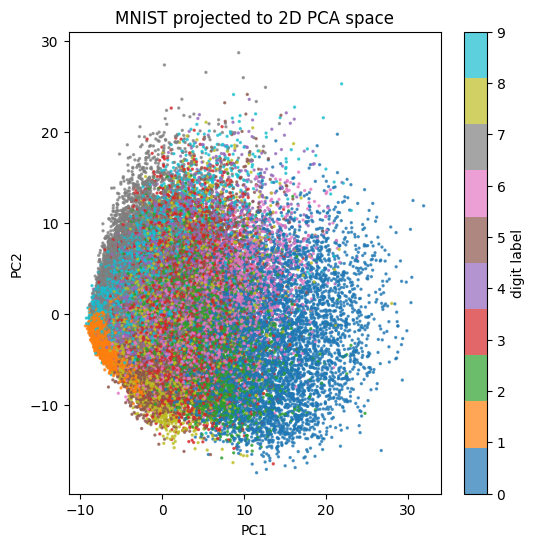

In [10]:
X2 = x_mnist_pca[2]
y = y_mnist.squeeze().astype(int)

plt.figure(figsize=(6,6))
plt.scatter(X2[:,0], X2[:,1],
            c=y, cmap="tab10",
            s=2, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST projected to 2D PCA space")
plt.colorbar(label="digit label")
plt.show()

#### 3d

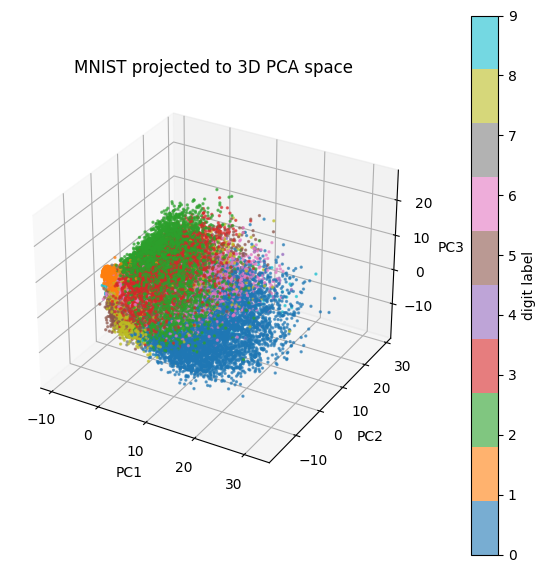

In [11]:
from mpl_toolkits.mplot3d import Axes3D

X3 = x_mnist_pca[3]
y = y_mnist.squeeze().astype(int)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=y, cmap="tab10",
    s=2, alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("MNIST projected to 3D PCA space")

cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("digit label")

plt.show()

#### Selected top PCA eigenvectors visualization

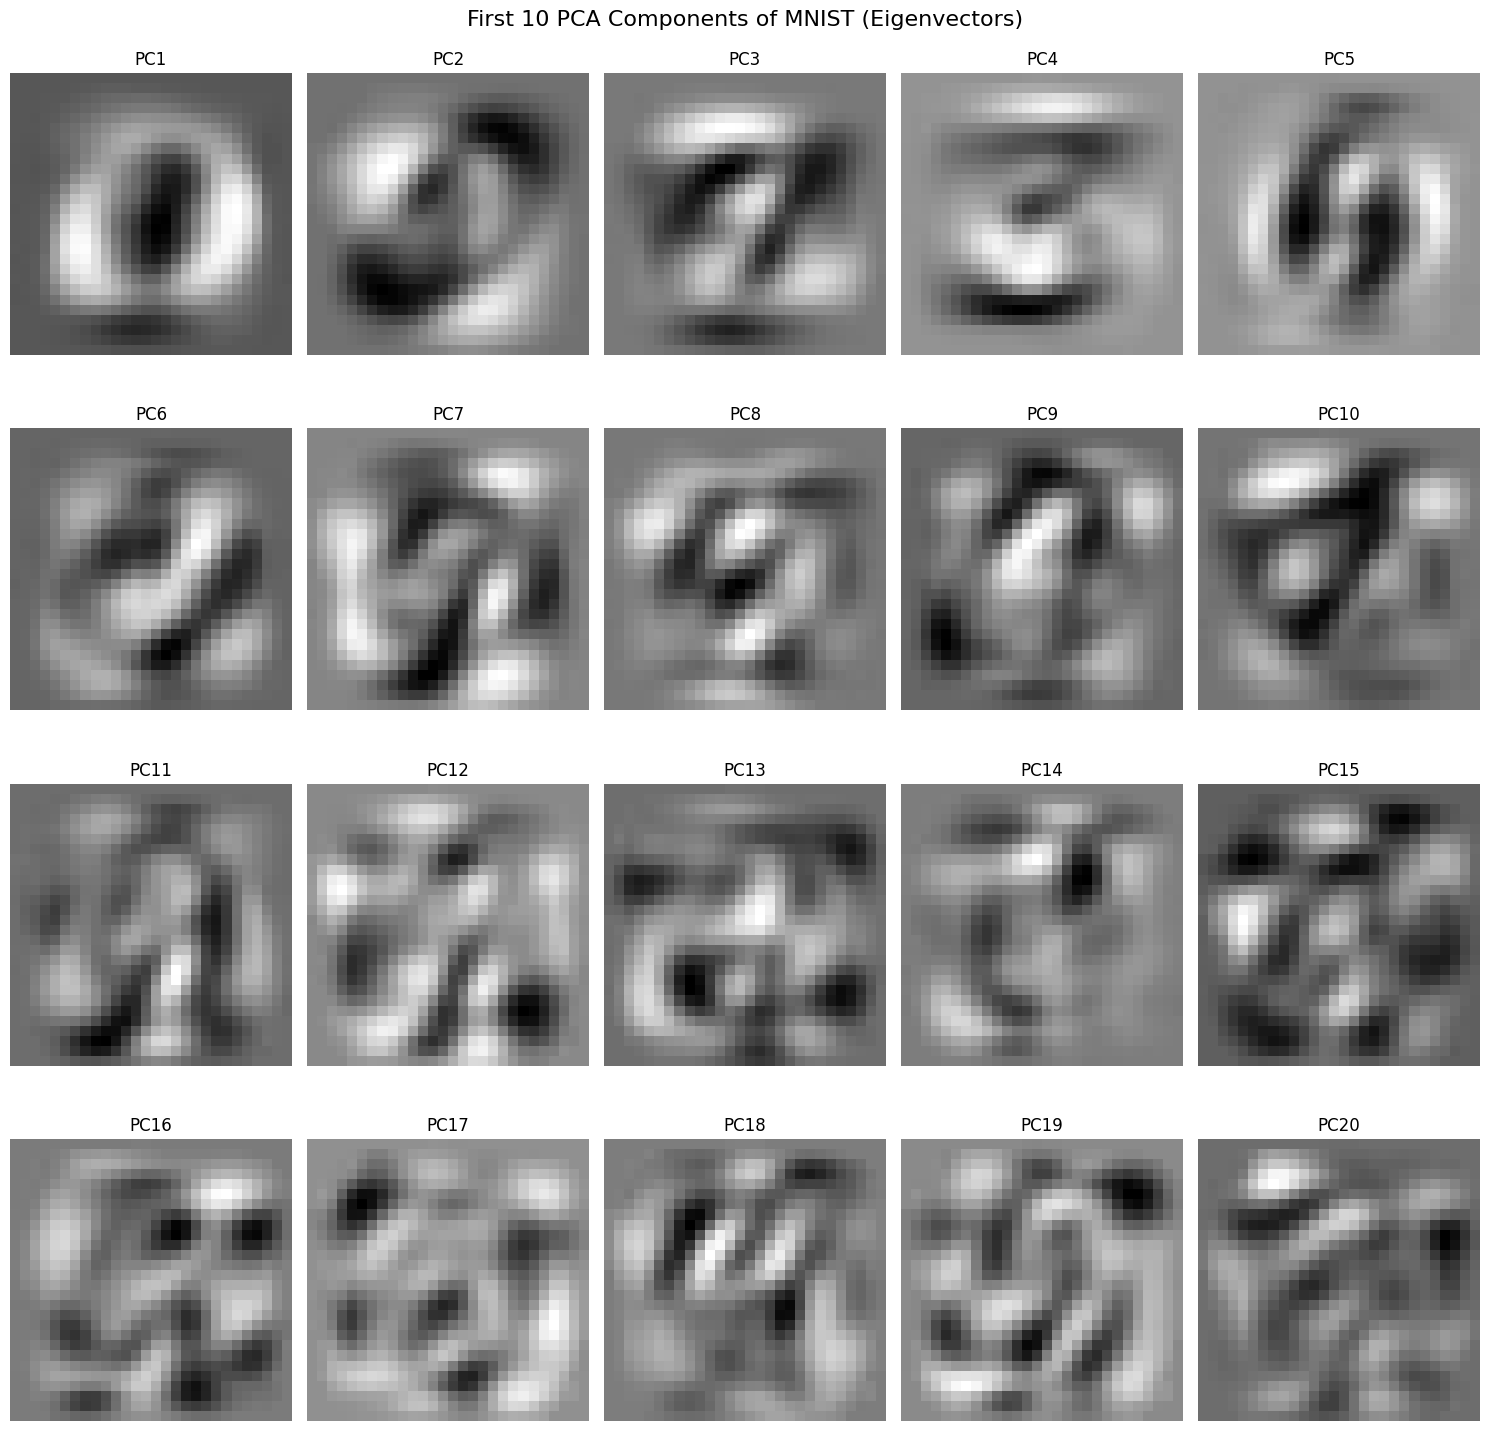

In [12]:
n_components_to_show = 20
components = pca_full.components_[:n_components_to_show]

plt.figure(figsize=(15,15))

for i in range(n_components_to_show):
    pc = components[i].reshape(28, 28)
    
    plt.subplot(int(n_components_to_show / 5), 5, i+1)
    plt.imshow(pc, cmap='gray')
    plt.title(f"PC{i+1}")
    plt.axis('off')

plt.suptitle("First 10 PCA Components of MNIST (Eigenvectors)", fontsize=16)
plt.tight_layout()
plt.show()

## 2.2 TODO: Covid Dataset

# 3. Step 3: K-means Clustering under Different PCA Dimensions & Evaluate
To examine how the representation space (i.e., different PCA dimensions) affects the cluster structure discovered by K-means.
## SOP
- Define PCA dimensions to test (done in Step 2)
- Transform dataset to each PCA space (done in Step 2)
- Run K-means for k=10
- Compute metrics comparing clusters to labels
- Visualize cluster scatter plots for low dims
- Summarize results in a table

## 3.1 For MNIST

### Run K-means for k=10 & Compute metrics comparing clusters to labels

In [13]:
results = {
    "dim": [],
    "ACC": [],
    "NMI": [],
    "ARI": [],
    "inertia": []
}

# ===== baseline: 784-d raw data =====
kmeans_raw = KMeans(n_clusters=10, n_init="auto", random_state=seed)
clusters_raw = kmeans_raw.fit_predict(x_mnist)

acc_raw, nmi_raw, ari_raw = evaluate_kmeans(y_mnist, clusters_raw)

results["dim"].append(x_mnist.shape[1])
results["ACC"].append(acc_raw)
results["NMI"].append(nmi_raw)
results["ARI"].append(ari_raw)
results["inertia"].append(kmeans_raw.inertia_ / x_mnist.shape[0])

print("K-means on raw data:")
print(f"  ACC: {acc_raw:.4f}")
print(f"  NMI: {nmi_raw:.4f}")
print(f"  ARI: {ari_raw:.4f}")
print("  Intra Inertia:",
      kmeans_raw.inertia_ / x_mnist.shape[0])


K-means on raw data:
  ACC: 0.4899
  NMI: 0.4299
  ARI: 0.3185
  Intra Inertia: 608.1481849071154


In [14]:
for d in pca_dims:
    Xd = x_mnist_pca[d]          # (70000, d)
    
    kmeans_d = KMeans(n_clusters=10, n_init="auto", random_state=seed)
    clusters_d = kmeans_d.fit_predict(Xd)
    
    acc_d, nmi_d, ari_d = evaluate_kmeans(y_mnist, clusters_d)
    inertia_d = kmeans_d.inertia_ / Xd.shape[0]
    
    results["dim"].append(d)
    results["ACC"].append(acc_d)
    results["NMI"].append(nmi_d)
    results["ARI"].append(ari_d)
    results["inertia"].append(inertia_d)
    
    # print(f"\nK-means on PCA dim={d}:")
    # print(f"  ACC: {acc_d:.4f}")
    # print(f"  NMI: {nmi_d:.4f}")
    # print(f"  ARI: {ari_d:.4f}")
    # print(f"  Inertia per point: {inertia_d:.4f}")


### Visualize cluster scatter plots for low dims

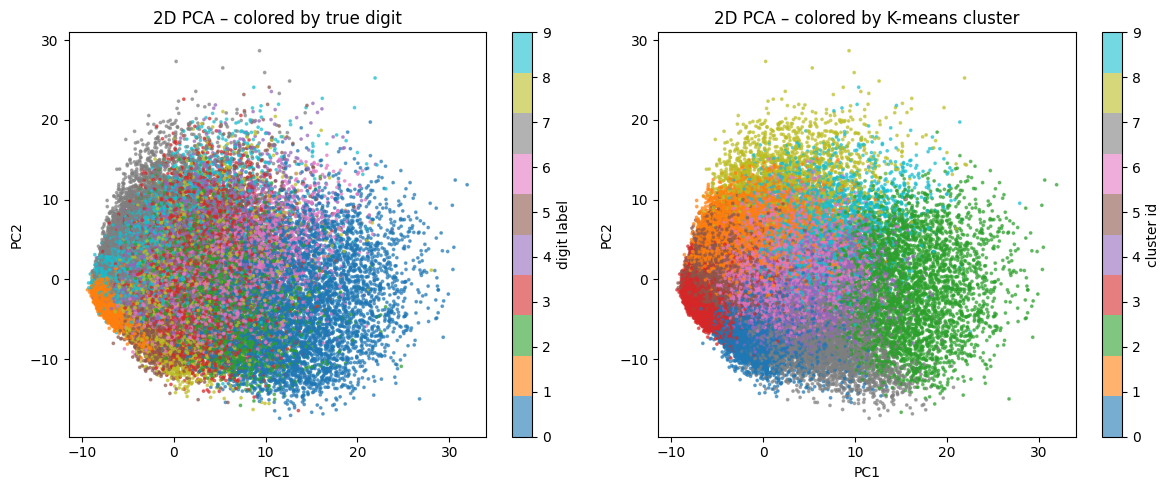

In [15]:
X2 = x_mnist_pca[2]
PCA_model2 = pca_models[2]
y_true = y_mnist.squeeze().astype(int)
y_cluster = clusters_raw.astype(int)

plt.figure(figsize=(12,5))

# ---- Left: true label ----
plt.subplot(1,2,1)
sc1 = plt.scatter(X2[:,0], X2[:,1],
                  c=y_true, cmap="tab10", s=3, alpha=0.6)
plt.title("2D PCA – colored by true digit")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar1 = plt.colorbar(sc1)
cbar1.set_label("digit label")

# ---- Right: K-means cluster ----
plt.subplot(1,2,2)
sc2 = plt.scatter(X2[:,0], X2[:,1],
                  c=y_cluster, cmap="tab10", s=3, alpha=0.6)
plt.title("2D PCA – colored by K-means cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar2 = plt.colorbar(sc2)
cbar2.set_label("cluster id")

plt.tight_layout()
plt.show()


## 3.2 TODO： Covid dataset

# 4. Compare with SVM

# 4.1 SVM for MNIST 

### Train/Test Split

In [18]:
X = x_mnist               
y = y_mnist

indices = np.arange(len(X))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=seed,
    stratify=y,
)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
y_train = y_train.ravel()
y_test = y_test.ravel()
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (56000, 784) (56000, 1)
Test shape: (14000, 784) (14000, 1)
Train shape: (56000, 784) (56000,)
Test shape: (14000, 784) (14000,)


### SVM on Raw data (takes a long time)

In [17]:
# # 4.2 Linear SVM on raw 784-d data
# svm_raw = LinearSVC(C=1.0, max_iter=3000, random_state=seed)

# svm_raw.fit(X_train, y_train)
# y_pred_raw = svm_raw.predict(X_test)

# acc_raw_svm = accuracy_score(y_test, y_pred_raw)
# print("SVM on raw 784-d data:")
# print(f"  Test ACC: {acc_raw_svm:.4f}")


### SVM on after PCA data

In [ ]:
pca_dims_for_svm = pca_dims[0:4]

svm_pca_results = {}

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

for d in pca_dims_for_svm:
    print(f"\n=== SVM on PCA dim = {d} ===")
    
    Xd = x_mnist_pca[d]

    X_train_d = Xd[train_idx]
    X_test_d  = Xd[test_idx]

    svm = LinearSVC(C=1.0, max_iter=300, dual=False, random_state=seed)
    svm.fit(X_train_d, y_train_flat)

    y_pred = svm.predict(X_test_d)
    acc = accuracy_score(y_test_flat, y_pred)
    svm_pca_results[d] = acc

    print(f"Test ACC with PCA dim={d}: {acc:.4f}")

print("\nSummary (SVM on PCA features):")
for d, acc in svm_pca_results.items():
    print(f"  dim={d:3d}  ACC={acc:.4f}")



=== SVM on PCA dim = 2 ===
Test ACC with PCA dim=2: 0.3204

=== SVM on PCA dim = 3 ===
Test ACC with PCA dim=3: 0.4214

=== SVM on PCA dim = 20 ===
Test ACC with PCA dim=20: 0.8458

=== SVM on PCA dim = 50 ===
Test ACC with PCA dim=50: 0.8919

Summary (SVM on PCA features):
  dim=  2  ACC=0.3204
  dim=  3  ACC=0.4214
  dim= 20  ACC=0.8458
  dim= 50  ACC=0.8919
